## Семинар 2 "Распознавание рукописных цифр"

ФИО: Евстифеев Степан Александрович

В этом задании мы используем нейронную сеть из предыдущего семинара для распознавания рукописных цифр. Также мы исследуем как влияет выбор нелинейности и предобработка данных на качество классификации. 

Чтобы не тратить время на подготовку данных, мы прилагаем готовый код с примером использования для получения обучающей и тестовой выборок. Для запуска скрипта вам понадобится библиотека PyTorch (инструкции по установке можно найти на сайте <a href="http://pytorch.org">pytorch.org</a>)

In [1]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from random import randint
import numpy as np
import sys
from layers import Linear, Sigmoid, NLLLoss, NeuralNetwork # Results from Seminar 1
from IPython.display import clear_output
%matplotlib inline

In [2]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [3]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

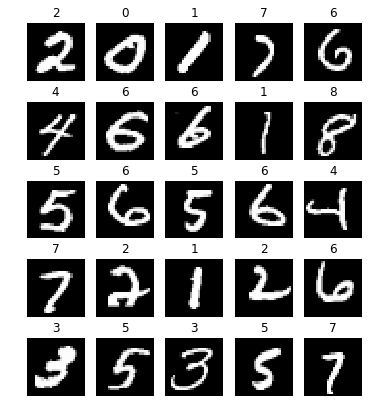

In [4]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

### Часть 1: MNIST
Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности. Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите 0.01

In [5]:
def train(network, epochs, learning_rate, plot=True, verbose=True, loss=None):
    loss = loss or NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            #learning_rate = learning_rate / (epoch + 1)
            losses = []
            accuracies = []
            for X, y in train_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                dLdx = loss.backward()
                network.backward(dLdx)
                network.step(learning_rate)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            if verbose:
                sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

In [6]:
network = NeuralNetwork([Linear(784, 100), Sigmoid(),
               Linear(100, 100), Sigmoid(),
               Linear(100, 10)])
loss = NLLLoss()

Epoch 19... (Train/Test) NLL: 0.306/0.301	Accuracy: 0.921/0.918

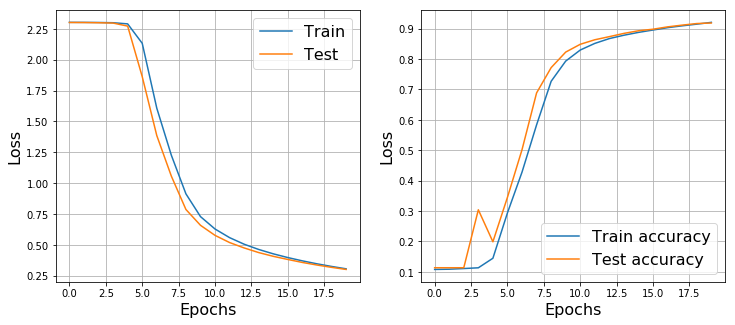

In [7]:
tr_s, ts_s, tr_ac_s, ts_ac_s = train(network, 20, 0.01)

### Часть 2: Нелинейности

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [6]:
class ReLU:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return np.maximum(X, 0)

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        dydX = (self.X >= 0).astype(float)
        return dLdy*dydX

    def step(self, learning_rate):
        pass

In [7]:
class ELU:
    '''
    ELU(x) = x, x > 0; a*(e^x - 1), x <= 0
    '''
    
    def __init__(self, a=1):
        self.a = a

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return X * (X > 0) + self.a * (np.exp(X) - 1) * (X <= 0)
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        X = self.X
        dydX = (X > 0) + self.a * np.exp(X) * (X <= 0)
        return dLdy*dydX

    def step(self, learning_rate):
        pass

In [10]:
network = NeuralNetwork([Linear(784, 100), ReLU(),
               Linear(100, 100), ReLU(),
               Linear(100, 10)])
loss = NLLLoss()
tr_r, ts_r, tr_ac_r, ts_ac_r = train(network, 20, 0.01, plot=False, verbose=False)

In [20]:
network = NeuralNetwork([Linear(784, 100), ELU(),
               Linear(100, 100), ELU(),
               Linear(100, 10)])
loss = NLLLoss()
tr_e, ts_e, tr_ac_e, ts_ac_e = train(network, 20, 0.01, plot=False, verbose=False)

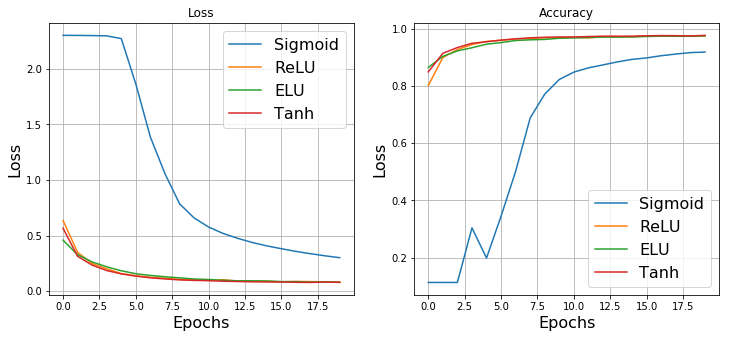

In [24]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_s, label='Sigmoid')
plt.plot(ts_r, label='ReLU')
plt.plot(ts_e, label='ELU')
plt.plot(ts_t, label='Tanh')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_s, label='Sigmoid')
plt.plot(ts_ac_r, label='ReLU')
plt.plot(ts_ac_e, label='ELU')
plt.plot(ts_ac_t, label='Tanh')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

### HW1 (1 балл): Реализовать Tanh

In [8]:
class Tanh:
    
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return np.tanh(self.X)
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        dydX = 1 - np.tanh(self.X)**2
        return dLdy*dydX

    def step(self, learning_rate):
        pass

Epoch 19... (Train/Test) NLL: 0.030/0.078	Accuracy: 0.994/0.977

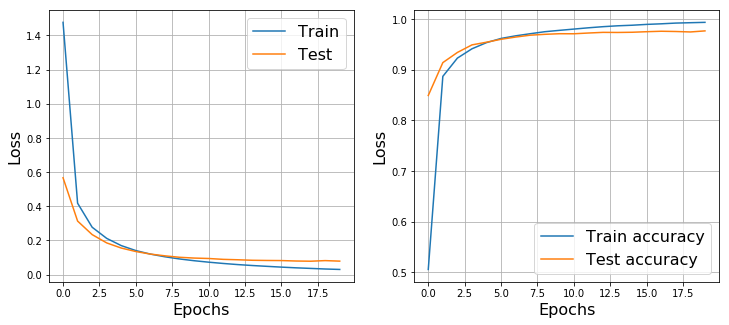

In [23]:
network = NeuralNetwork([Linear(784, 100), Tanh(),
               Linear(100, 100), Tanh(),
               Linear(100, 10)])
loss = NLLLoss()
tr_t, ts_t, tr_ac_t, ts_ac_t = train(network, 20, 0.01, plot=True, verbose=True)

In [29]:
activation_funcs = ['Sigmoid', 'Tanh', 'ELU', 'ReLU']
best_scores = [np.max(ts_ac_s), np.max(ts_ac_t), np.max(ts_ac_e), np.max(ts_ac_r)]
for activation_func, best_score in zip(activation_funcs, best_scores):
    print("Best score on test set: {0:.4f} with {1} activation".format(best_score, activation_func))

Best score on test set: 0.9184 with Sigmoid activation
Best score on test set: 0.9768 with Tanh activation
Best score on test set: 0.9748 with ELU activation
Best score on test set: 0.9753 with ReLU activation


### Часть 3: Анализ ошибок

In [30]:
wrong_X = []
correct_y = []
predicted_y = []
logits = []
for X, y in test_loader:
    X = X.view(X.shape[0], -1).numpy()
    y = y.numpy()
    prediction = network.forward(X)
    prediction = np.exp(prediction)
    prediction /= prediction.sum(1, keepdims=True)
    for i in range(len(prediction)):
        if np.argmax(prediction[i]) != y[i]:
            wrong_X.append(X[i])
            correct_y.append(y[i])
            predicted_y.append(np.argmax(prediction[i]))
            logits.append(prediction[i][y[i]])
wrong_X = np.row_stack(wrong_X)
correct_y = np.row_stack(correct_y)[:, 0]
predicted_y = np.row_stack(predicted_y)[:, 0]
logits = np.row_stack(logits)[:, 0]

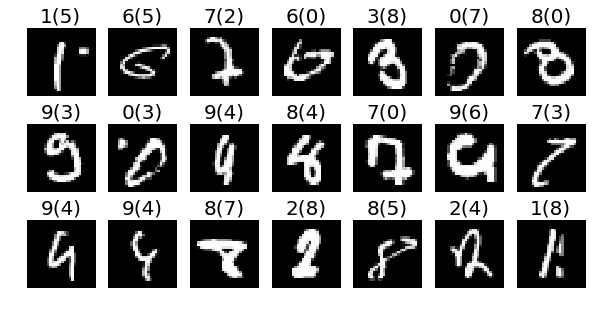

In [31]:
plt.figure(figsize=(10, 5))
order = np.argsort(logits)
for i in range(21):
    plt.subplot(3, 7, i+1)
    plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title('{}({})'.format(correct_y[order[i]], predicted_y[order[i]]), fontsize=20)
    plt.axis('off')

### Часть 4: Аугментация (HW, 2 балла)
* Небольшие вращения (-15, 15)
* Случайные сдвиги
* Шум

Какой прирост дают эти аугментации вместе и по отдельности

In [ ]:
from PIL import Image, ImageFilter

class Rotate(object):
    def __init__(self, degrees):
        self.degrees = degrees

    def __call__(self, image):
        random_angle = randint(self.degrees[0], self.degrees[1])
        rotated = rotate(np.array(image), random_angle, resize=False)
        return Image.fromarray(rotated)

class Noise(object):
    def __init__(self, nu, sigma):
        self.nu = nu
        self.sigma = sigma

        
    def __call__(self, image):
        np_img = np.array(image)
        #print(np_img)
        noise = np.random.normal(self.nu, self.sigma, np_img.shape)
        return Image.fromarray(np_img + noise)

### Использование всех аугментаций

In [ ]:
from skimage.transform import rotate
transform = transforms.Compose([
                       Rotate((-15, 15)),
                       transforms.RandomAffine(0, (0.1, 0.1)),
                       Noise(0, 0.01),
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

In [ ]:
network = NeuralNetwork([Linear(784, 100), ReLU(),
               Linear(100, 100), ReLU(),
               Linear(100, 10)])
loss = NLLLoss()
tr_aug, ts_aug, tr_ac_aug, ts_ac_aug = train(network, 30, 0.01, plot=True, verbose=True)

In [ ]:
print("{0:.4f} on train, {1:.4f} accuracy on test set with full aug".format(np.max(tr_ac_aug), np.max(ts_ac_aug)))

## Аугментация поворотом и сдвигом

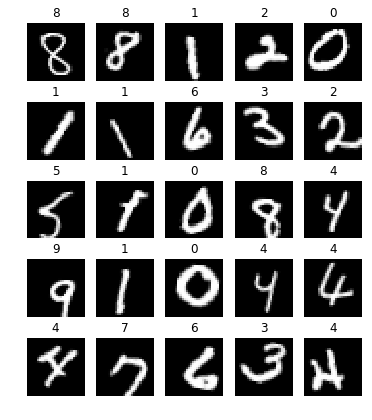

In [13]:
from skimage.transform import rotate
transform = transforms.Compose([
                       Rotate((-15, 15)),
                       transforms.RandomAffine(0, (0.1, 0.1)),
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

Epoch 19... (Train/Test) NLL: 0.071/0.087	Accuracy: 0.979/0.974

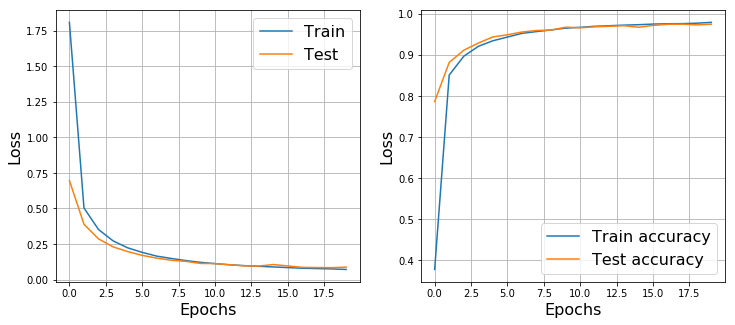

In [18]:
network = NeuralNetwork([Linear(784, 100), ReLU(),
               Linear(100, 100), ReLU(),
               Linear(100, 10)])
loss = NLLLoss()
tr_affine, ts_affine, tr_ac_affine, ts_ac_affine = train(network, 20, 0.01, plot=True, verbose=True)

## Аугментации сдвигом

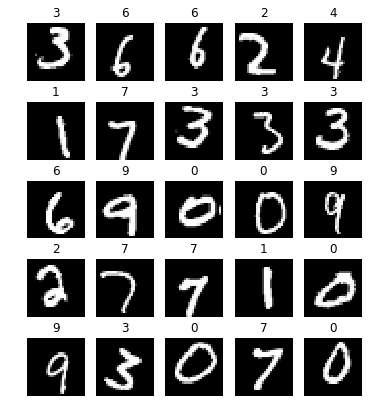

In [24]:
from skimage.transform import rotate
transform = transforms.Compose([
                       transforms.RandomAffine(0, (0.1, 0.1)),
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

Epoch 19... (Train/Test) NLL: 0.116/0.115	Accuracy: 0.965/0.964

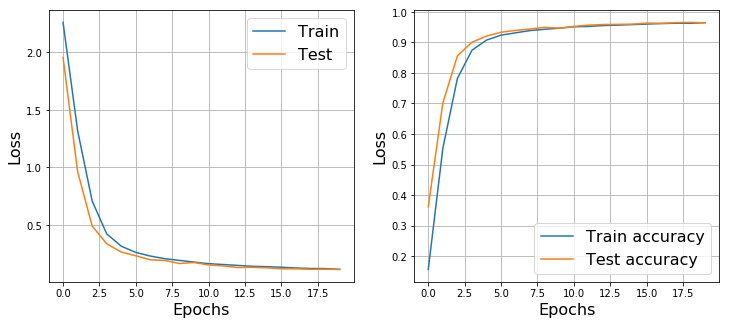

In [25]:
network = NeuralNetwork([Linear(784, 100), ReLU(),
               Linear(100, 100), ReLU(),
               Linear(100, 10)])
loss = NLLLoss()
tr_shift, ts_shift, tr_ac_shift, ts_ac_shift = train(network, 20, 0.01, plot=True, verbose=True)

## Аугментация поворотом

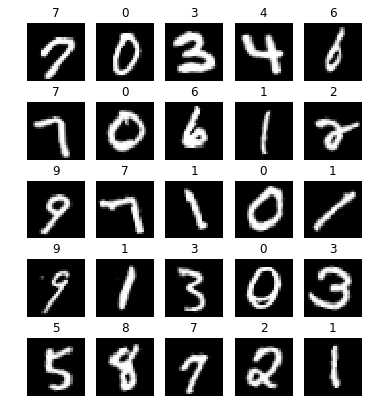

In [15]:
from skimage.transform import rotate
transform = transforms.Compose([
                       Rotate((-15, 15)),
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

Epoch 19... (Train/Test) NLL: 0.070/0.077	Accuracy: 0.979/0.976

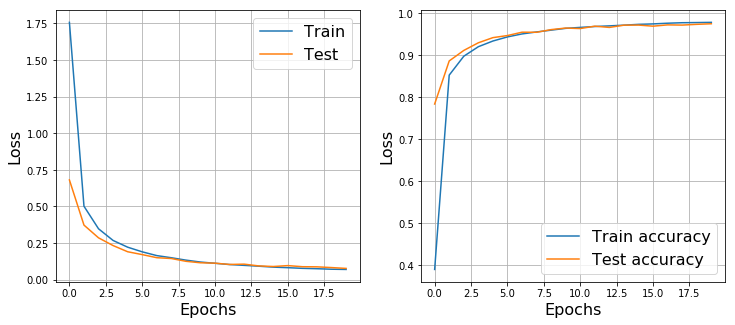

In [16]:
network = NeuralNetwork([Linear(784, 100), ReLU(),
               Linear(100, 100), ReLU(),
               Linear(100, 10)])
loss = NLLLoss()
tr_rotate, ts_rotate, tr_ac_rotate, ts_ac_rotate = train(network, 20, 0.01, plot=True, verbose=True)

In [29]:
test_augmentation_scores = [ts_ac_aug, ts_ac_affine, ts_ac_shift, ts_ac_rotate, [0.9768]]
augmentation_type = ["Full", "Affine", "Shift", "Rotate", "no"]
for score, aug_type in zip(test_augmentation_scores, augmentation_type):
    print("{0:.5f} accuracy on test set with {1} augmentation".format(np.max(score), aug_type))

0.96176 accuracy on test set with Full augmentation
0.97444 accuracy on test set with Affine augmentation
0.96585 accuracy on test set with Shift augmentation
0.97554 accuracy on test set with Rotate augmentation
0.97680 accuracy on test set with no augmentation


### Часть 5: Выводы
Опишите полученные результаты: как влияют выбор нелинейности и предобработка данных на скорость сходимости и итоговое качество?

**Нелинейность**:
* **Sigmoid** - сходиться наиболее медленно из-за затухающего градиента, а также имеет наименьшую точность на тренировочной и тестовой выборках (0.9184).
* **ReLu, ELU, Tanh** - сходятся довольно быстро на MNIST (7 эпоха), т.к данные функций активации менее подвержены проблеме затухающего градиента, соотвественно точность также повышается. Наилучшая точность у Tanh (0.9768).

**Аугментация**:
* **Полные аугментации, без шума и аффинные преобразования** - сеть сходиться медленно, возможно это связано с переобучением на шуме и сдвигах. Точность в среднем также уменьшается.
* **Аугментация поворотом** - сеть сходиться чуть медленнее, но при этом дает соизмеримо высокую точность (0.9755). При этом сеть продолжает обучаться после 20 эпох.

Таким образом аугментация может увеличить точность, но при этом скорость сходимости немного снижается, но требуется аккуратность при подборе трансформаций.